In [1]:
import numpy as np
import vtk
import myvtk
import glob
import pandas as pd
from myvtk.GetMakeVtk import makeVtkFile, GetMyVtk, measure_length
from myvtk.General import mkdir
import os
import re
from collections import Counter 
# import pydot
from networkx.drawing.nx_pydot import graphviz_layout 
import networkx as nx
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
import tqdm

kmeans_dir = mkdir(".\\", "kmeans")

# 判断两条线是否相连
def connect_or_not(a,b):
    #a = [1,2,3]
    #b = [4,5,6]
    c = np.zeros(len(a)+len(b))
    c[:len(a)] = a
    c[len(a):] = b
    len_1 = len(a)+len(b)
    len_2 = len(set(c))
    if (len_1 == len_2): 
        return 0
    else:
        return True

def max_mean_radius(u,v, lines, radius): # u, v are line idx.
    # print (len(lines), len(radius))
    pt_in_u = lines[u]
    pt_in_v = lines[v]
    avg_r_u = 0
    avg_r_v = 0
    for i in pt_in_u:
        avg_r_u += radius[i]
    for i in pt_in_v:
        avg_r_v += radius[i]
    avg_r_v = avg_r_v/len(pt_in_v)
    avg_r_u = avg_r_u/len(pt_in_u)
    return 1/(min(avg_r_u,avg_r_v))


generating in directory .\kmeans\...


In [4]:
files = glob.glob('D:\\!BraVa_src\\Brava\\domain\\src\\*.vtk')
c_mats = []
domains = []
pts = []
lns = []
rs = []
avg_r=[]
for f in range(len(files)):
    f_name = files[f].split('\\')[-1].split('.')[0] # 找到文件名
    # 打开vtk文件，读出里面的LINES
    d = open(files[f],"r")
    data = d.readlines()
    d.close()
    

    for i in range(len(data)):
        if data[i][:6] == 'POINTS':
            point_num = int(data[i].split(" ")[1])
            # print ("point_num", point_num)
            points = data[i+1:i+point_num+1]
            for j in range(len(points)): 
                points[j] = points[j][:-2].split(' ')
                for k in range(len(points[j])):
                    points[j][k] = float(points[j][k])
            pts.append(points)

        if data[i][:5] == 'LINES':
            line_num = int(data[i].split(" ")[1])
            # LINES后面的第一个数字是血管的总条数
            lines = data[i+1:i+line_num+1]
            for j in range(0, len(lines)):
                # print ("lines[j]:", lines[j])
                lines[j] = lines[j][:-2].split(' ')[1:]
                for k in range(len(lines[j])):
                    lines[j][k] = int(lines[j][k])
            lns.append(lines)
            

        if "Radius" in data[i]:
            radius = data[i+2:i+2+point_num]
            for j in range(len(radius)): 
                radius[j] = float(radius[j])
            rs.append(radius)

        if "Domain" in data[i]:
            domain = data[i+2:i+2+line_num]
            for j in range(len(domain)):
                domain[j] = int(domain[j])
            domains.append(domain)
            break

    connect_mat = np.zeros((line_num, line_num))
    for j in range(len(lines)):
        for k in range(len(lines)):
            if j != k:
                connect_mat[j][k] = connect_or_not(lines[j], lines[k]) 
                # connect_mat[j][k] = max_mean_radius(j,k, lines, radius) * connect_or_not(lines[j], lines[k]) 
    c_mats.append(connect_mat)

    avg_radius = np.zeros(line_num)
    for j in range(line_num):
        # print (type(lines[j]))
        avg_radius[j] =  np.mean( np.array(radius)[np.array(lines[j])]) 
    avg_r.append(avg_radius)
    
    
            
print ("done")
print (len(c_mats),len(pts),len(lns),len(rs))

done
52 52 52 52


In [10]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

s_path = "./Domain_separate/"

subsets_dir = mkdir(".\\","subsets")

cluster_dir=mkdir(".\\","cluster")
for j  in range(len(c_mats)):
# for j in [0,1,2]:
    lines = lns[j]
    points = pts[j]
    radius = rs[j]
    f_name = files[j].split('\\')[-1].split('.')[0]
    ss_dir=mkdir(subsets_dir,f_name)
    sep_domain_dir = mkdir(s_path, f_name)
    vtkfile = open(files[j], "r")
    vtktext = vtkfile.read()
    vtkfile.close()
    new_vtkfile = open(cluster_dir+f_name+".vtk","w+")
    new_vtkfile.write(vtktext)
    temp_mat = c_mats[j]
    distance_mat = np.zeros_like(temp_mat)
    G=nx.from_numpy_array(temp_mat)
    times = (np.array(G.degree())[:,1])
    terminal_num = np.sum(times == 2) - 3

    max_indice = []
    # max1 = sorted(avg_r[j],reverse=True)[0]
    # max2 = sorted(avg_r[j],reverse=True)[1]
    for i in range(10):
        max_value = sorted(avg_r[j],reverse=True)[i]
        max_idx = np.where(avg_r[j]==max_value)[0][0]
        if G.degree(max_idx) ==2:
            max_indice.append(max_idx)

    passed = np.zeros(len(temp_mat))
    for rt in max_indice:
        if np.array(G.degree())[rt,1] ==2:
            p = nx.shortest_path(G, source=rt, weight="weight", method='dijkstra')
            for target in range(len(temp_mat)):
                p_length = nx.shortest_path_length(G, source=rt, target=target)
                distance_mat[rt][target] = p_length
                # print ("p[target]",p[target])
                for node in p[target]:
                    # print ()
                    passed[node]+=1

    norm_distance_mat = preprocessing.normalize(distance_mat)
    # norm_rt_distance_mat = preprocessing.normalize(rt_distance_mat)
    kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto", max_iter=10000).fit(norm_distance_mat)

    pca = PCA(n_components=10)
    feature = pca.fit_transform(norm_distance_mat)
    kmeans_f = KMeans(n_clusters=7, random_state=0, n_init="auto", max_iter=10000).fit(feature)
    cow_indx = kmeans.predict([distance_mat[0]])
    new_vtkfile.write("SCALARS ICA int\nLOOKUP_TABLE default\n")
    new_vtkfile.write("0\n") # BA
    for i in range(1, len(temp_mat)):
        if i in max_indice: # ICA
            output=-1
        else:
            output = int(passed[i])
        new_vtkfile.write("{}\n".format(output))
    new_vtkfile.close()

    # counts, bins = np.histogram(passed, bins=(len(lines)//5))
    # # print (counts)
    # print (bins)
    # fig,ax=plt.subplots()
    # # ax = plt.stairs(counts, bins)
    # ax = plt.hist(bins[:-1], bins, weights=counts)
    # plt.savefig("./hist/{}.png".format(f_name))
    # plt.close()
    # print ("max_indice:", max_indice)

    
    percent = 77
    print("percentile ",percent,  np.percentile(passed, percent))
    f_idx = 0
    for i in range(len(passed)):
        coords = []
        for pt_idx in lines[i]:
            coords.append(points[pt_idx])
        coords = np.array(coords)
        makeVtkFile(sep_domain_dir+"{:0=3}.vtk".format(int(i)), coords, [],[])
        
        
        # if (passed[i] > np.percentile(passed, percent)) or (i in max_indice) or (i == 0):
        #     coords = []
        #     for pt_idx in lines[i]:
        #         coords.append(points[pt_idx])
        #     coords = np.array(coords)
        #     makeVtkFile(ss_dir+"{:0=3}_passed_{:0=3}.vtk".format(int(passed[i]), int(f_idx)), coords, [],[])
        #     f_idx+=1
    # print (passed)




generating in directory .\subsets\...
generating in directory .\cluster\...
generating in directory .\subsets\BG0002\...
making new directory ./Domain_separate/BG0002\...
percentile  77 21.0
generating in directory .\subsets\BG0014\...
making new directory ./Domain_separate/BG0014\...
percentile  77 21.0
generating in directory .\subsets\BG0019\...
making new directory ./Domain_separate/BG0019\...
percentile  77 14.0
generating in directory .\subsets\BG0020\...
making new directory ./Domain_separate/BG0020\...
percentile  77 21.0
generating in directory .\subsets\BG0021\...
making new directory ./Domain_separate/BG0021\...
percentile  77 28.0
generating in directory .\subsets\BG0022\...
making new directory ./Domain_separate/BG0022\...
percentile  77 14.0
generating in directory .\subsets\BG04\...
making new directory ./Domain_separate/BG04\...
percentile  77 27.0
generating in directory .\subsets\BG09\...
making new directory ./Domain_separate/BG09\...
percentile  77 21.0
generating i

正確のブロック分けではなく、CoWでないブロックを削ることだけをもくてきとする    

In [ ]:
    # new_vtkfile.write("SCALARS Cluster int\nLOOKUP_TABLE default\n")
    # for i in range(len(kmeans.labels_)):
    #     new_vtkfile.write("{}\n".format(kmeans.labels_[i]))
    #     # if kmeans.labels_[i] == cow_indx:
    #     #     new_vtkfile.write("{}\n".format(1))
    #     # else:
    #     #     new_vtkfile.write("{}\n".format(0))
    # new_vtkfile.write("SCALARS pca_Cluster int\nLOOKUP_TABLE default\n")
    # for i in range(len(kmeans_f.labels_)):
    #     new_vtkfile.write("{}\n".format(kmeans_f.labels_[i]))

In [95]:
    # pca = PCA(n_components=10)
    # feature = pca.fit_transform(norm_distance_mat)

    # kmeans_f = KMeans(n_clusters=7, random_state=0, n_init="auto", max_iter=10000).fit(feature)
    # # print (len(feature))

    # fig = plt.figure()
    # ax1=fig.add_subplot(121)
    # ax2=fig.add_subplot(122)
    # ax1.scatter(feature[:,0], feature[:,1], c =kmeans.labels_, s=10)
    # ax2.scatter(feature[:,0], feature[:,1], c =kmeans_f.labels_, s=10)
    # plt.savefig(kmeans_dir+f_name+".png")
    # plt.close()

[1 1 1 0 0 2 2]


[[0.         0.00634005 0.01341554 ... 0.01141208 0.01848758 0.01848758]
 [0.00707969 0.         0.00637172 ... 0.01274345 0.02064438 0.02064438]
 [0.01464695 0.00693803 0.         ... 0.02081409 0.02941725 0.02941725]
 ...
 [0.00688436 0.00688436 0.01032654 ... 0.         0.00807132 0.01101497]
 [0.01346063 0.01346063 0.01655872 ... 0.00726447 0.         0.00991386]
 [0.01553948 0.01553948 0.01852784 ... 0.00956276 0.00956276 0.        ]]


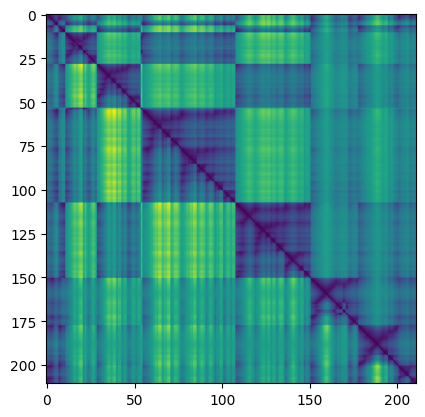

In [40]:
plt.imshow(norm_distance_mat)
print (norm_distance_mat)

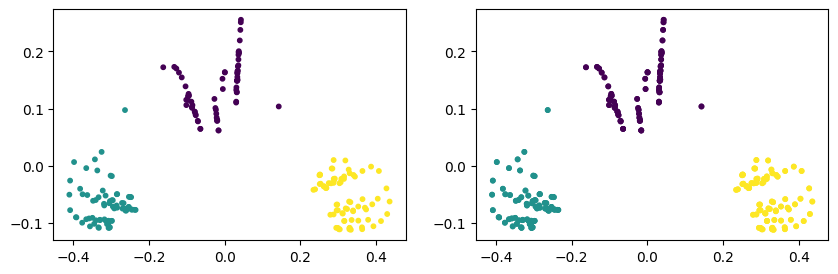

In [45]:
fig = plt.figure(figsize=(10,3))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

pca = PCA(n_components=3)
feature = pca.fit_transform(norm_distance_mat)


kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto", max_iter=10000).fit(norm_distance_mat)
plt.scatter(feature[:,0], feature[:,1], c =kmeans.labels_, s=10)

kmeans_f = KMeans(n_clusters=3, random_state=0, n_init="auto", max_iter=10000).fit(feature)
# print (len(feature))

ax1.scatter(feature[:,0], feature[:,1], c =kmeans.labels_, s=10)
ax2.scatter(feature[:,0], feature[:,1], c =kmeans_f.labels_, s=10)
#plt.savefig(kmeans_dir+f_name+".png")
#plt.close()

In [10]:
a = [1,2,3,3,3,4,5,6,7,8]
print (np.percentile(a,90))

7.1
